In [236]:
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
%matplotlib inline


Загрузить данные в pandas


In [237]:
df = pd.read_csv('u.data', sep='\t', names=['user_Id', 'movie_id','rating','date'])

In [238]:
genre = pd.read_csv('u.genre', sep='|', names=['genre', 'genre_Id']) 

In [239]:
info = pd.read_csv('u.info', sep='|')

In [240]:
item = pd.read_csv('u.item', sep='|', names =['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

In [241]:
occupation = pd.read_csv('u.occupation', sep='|')

In [242]:
user = pd.read_csv('u.user', sep='|',  names=['user_Id', 'age','gender','occupation' ,'zip_code'])

Посчитайте среднюю оценку, которую поставил каждый пользователь

In [243]:
df.groupby('user_Id').mean().reset_index()[['user_Id', 'rating']].sort_values('rating', ascending=False).head(20)

,user_Id,rating
848,849,4.869565
687,688,4.833333
506,507,4.724138
627,628,4.703704
927,928,4.687500
117,118,4.661972
906,907,4.571429
685,686,4.563380
426,427,4.548387
564,565,4.542857


Отсортируйте фильмы по количеству оценок

In [244]:
df.groupby('movie_id').count().sort_values('rating', ascending=False).head(20).reset_index()[['movie_id', 'rating']]

,movie_id,rating
0,50,583
1,258,509
2,100,508
3,181,507
4,294,485
5,286,481
6,288,478
7,1,452
8,300,431
9,121,429



Средствами pandasa соедините данные по оценкам с данными по пользователям (u.user)


In [245]:
df_u = pd.merge(df, user, on='user_Id', how='inner')

In [246]:
df_u.head()

,user_Id,movie_id,rating,date,age,gender,occupation,zip_code
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


Построить модель, которая предсказывает оценку для фильма и пользователя (воспользоваться RandomForestRegressor, тк мы решаем задачу регрессии)

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error

In [248]:
df_u['gender'] =  df_u['gender'].map({'M': 1, 'F': 0}) 

In [249]:
label, name = pd.factorize(df_u['occupation'])

In [250]:
df_u['occupation'] = label

In [251]:
df_u.head()

,user_Id,movie_id,rating,date,age,gender,occupation,zip_code
0,196,242,3,881250949,49,1,0,55105
1,196,393,4,881251863,49,1,0,55105
2,196,381,4,881251728,49,1,0,55105
3,196,251,3,881251274,49,1,0,55105
4,196,655,5,881251793,49,1,0,55105


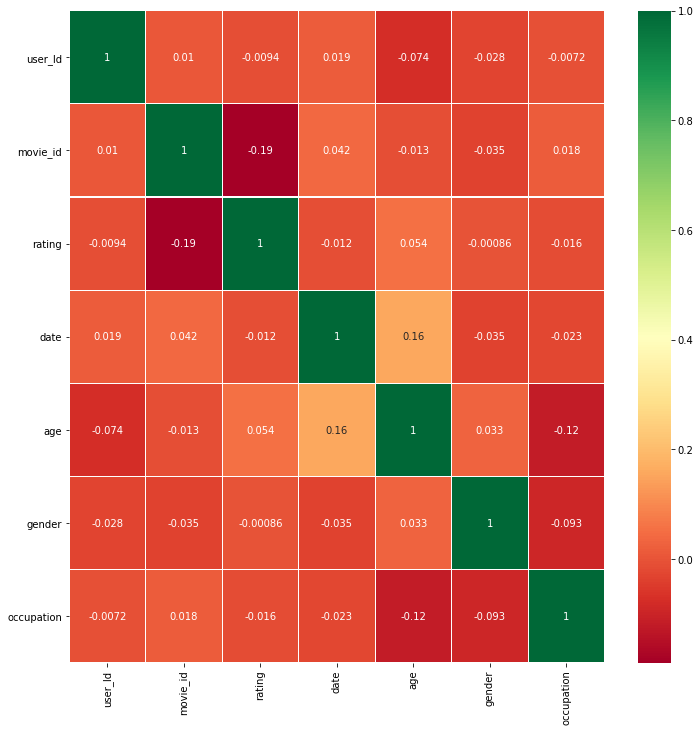

In [252]:
sns.heatmap(df_u.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

по матрице можно заметить, что очень низкая связь почти у всех показателей, использую только данный датафрейм высокое качество модели будет трудно получить

In [253]:
X = df_u[['user_Id', 'movie_id','occupation','age']]
y = df_u['rating']

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [255]:
model = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=1)

In [256]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [257]:
predict = model.predict(X_test)

Оценить качество регрессора на отложенной (train_test_split) выборке по одной из метрик на выбор - RMSE, RMAE, R^2

In [258]:
r2_score(y_test, predict )

0.1346647102462517

Как и ожидалось, качество очень низкое

In [259]:
df_union = pd.merge(df_u, item, on='movie_id', how='inner')

In [260]:
df_union.columns

Index(['user_Id', 'movie_id', 'rating', 'date', 'age', 'gender', 'occupation',
       'zip_code', 'movie_title', 'release_date', 'video_release_date',
       'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [261]:
X = df_union[['user_Id', 'movie_id', 'rating', 'age', 'gender', 'occupation',  'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir','Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western']]
y = df_union['rating']

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [263]:
model = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=1)

In [264]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [265]:
predict_try_2 = model.predict(X_test)

In [266]:
r2_score(y_test, predict_try_2 )

1.0

Получилось пугающе высокое качетсво

In [267]:
predict_all = model.predict(X)

In [268]:
df_union['Predict'] = predict_all

In [271]:
df_union[['user_Id', 'movie_id', 'rating','Predict']].head()

,user_Id,movie_id,rating,Predict
0,196,242,3,3.0
1,305,242,5,5.0
2,6,242,4,4.0
3,234,242,4,4.0
4,63,242,3,3.0
